### 🏃🏻‍♀️Sideproject Apple watch / health 데이터 분석 및 시각화
**분석 목표**
> - 태블로 시각화
> - 시계열 분석

# Import module

In [2]:
# visualization
# permission error 해결 --user
#!pip install --user panel
#!pip install altair
#! pip install vega
import panel as pn
import altair as alt
from altair import datum
import datetime as dt

In [1]:
import pandas as pd

In [3]:
#pip install xmltodict
import xmltodict

# Load data

In [17]:
energy = pd.read_csv('data/ActiveEnergyBurned.csv', encoding='CP949')
heart = pd.read_csv('data/HeartRate.csv', encoding='CP949')
audio = pd.read_csv('data/AudioExposure.csv', encoding='CP949')
distance = pd.read_csv('data/DistanceWalkingRunning.csv', encoding='CP949')
exercise = pd.read_csv('data/AppleExerciseTime.csv', encoding='CP949')

C:\Users\JIIN\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3170: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
step = pd.read_csv('data/StepCount.csv', encoding='CP949')
walkspeed = pd.read_csv('data/WalkSpeed.csv', encoding='CP949')

In [64]:
input_path = 'export.xml'
with open(input_path, 'rt', encoding='UTF8') as xml_file:
    input_data = xmltodict.parse(xml_file.read())
#Records list for general health data & imported as Pandas Data Frame
records_list = input_data['HealthData']['Record']
df_records = pd.DataFrame(records_list)
#Workout list for workout data
workouts_list = input_data['HealthData']['Workout']
df_workouts = pd.DataFrame(workouts_list)

# Preprocessing

## df_watch

In [65]:
# remove @ from colnames
new_col=[]
for col in df_workouts.columns :
    temp = col.replace('@','')
    new_col.append(temp)
df_workouts.columns = new_col

In [66]:
# maintain raw data
df_workouts_raw = df_workouts.copy()

In [67]:
# Convert selected columns to numeric so we can do calcuations
# convert just columns "..." and "..."
df_workouts[["duration", "totalDistance", "totalEnergyBurned"]] = df_workouts[["duration", "totalDistance", "totalEnergyBurned"]].apply(pd.to_numeric)
df_workouts.dtypes
#convert dates to actual datetime
format = '%Y-%m-%d %H:%M:%S %z'
df_workouts['creationDate'] = pd.to_datetime(df_workouts['creationDate'],format=format)
df_workouts['startDate'] = pd.to_datetime(df_workouts['startDate'], format=format)
df_workouts['endDate'] = pd.to_datetime(df_workouts['endDate'],format=format)
df_workouts.dtypes
#drop unnecessary columns (all rows and column 1 to 12)
df_workouts = df_workouts.iloc[:,0:12]
df_workouts.head()
#Remove HKWorkoutActivityTypeWalking and HKWorkoutActivityTypeSnowSports
df_workouts=df_workouts[df_workouts['workoutActivityType'] != 'HKWorkoutActivityTypeWalking']
df_workouts=df_workouts[df_workouts['workoutActivityType'] != 'HKWorkoutActivityTypeSnowSports']

In [62]:
df_workouts.workoutActivityType.value_counts()

HKWorkoutActivityTypeHighIntensityIntervalTraining    154
HKWorkoutActivityTypeTraditionalStrengthTraining      152
Running                                               119
Cycling                                                75
HKWorkoutActivityTypeStairClimbing                     18
HKWorkoutActivityTypeStairs                            18
HKWorkoutActivityTypeFunctionalStrengthTraining        15
HKWorkoutActivityTypeHiking                            11
HKWorkoutActivityTypeMixedCardio                        3
Name: workoutActivityType, dtype: int64

In [71]:
#Rename Activity Types to Running, Cycling and Swimming
df_workouts['workoutActivityType']= df_workouts['workoutActivityType'].apply(lambda x : str(x).replace('HKWorkoutActivityType',''))

In [72]:
df_workouts.head()

,workoutActivityType,duration,durationUnit,totalDistance,totalDistanceUnit,totalEnergyBurned,totalEnergyBurnedUnit,sourceName,sourceVersion,creationDate,startDate,endDate
0,Running,30.077727,min,5.009363,km,246.292,kcal,Nike Run Club,1809192025,2018-10-06 22:41:26+09:00,2018-10-06 22:09:25+09:00,2018-10-06 22:41:13+09:00
1,Running,18.196028,min,3.013672,km,150.578,kcal,Nike Run Club,1809192025,2018-10-07 23:03:56+09:00,2018-10-07 22:37:40+09:00,2018-10-07 23:03:48+09:00
2,Running,11.088048,min,1.914857,km,95.863,kcal,Nike Run Club,1809192025,2018-10-09 22:54:36+09:00,2018-10-09 22:34:22+09:00,2018-10-09 22:52:32+09:00
3,Running,29.542504,min,5.026577,km,252.933,kcal,Nike Run Club,1809192025,2018-10-11 23:42:45+09:00,2018-10-11 23:08:10+09:00,2018-10-11 23:42:38+09:00
4,Running,18.002057,min,3.028296,km,156.366,kcal,Nike Run Club,1809192025,2018-10-13 19:27:29+09:00,2018-10-13 19:09:17+09:00,2018-10-13 19:27:23+09:00


In [73]:
df_watch=df_workouts.query('(sourceName!="Nike Run Club")&(sourceName!="Nike Training")').reset_index(drop=True)
df_watch

,workoutActivityType,duration,durationUnit,totalDistance,totalDistanceUnit,totalEnergyBurned,totalEnergyBurnedUnit,sourceName,sourceVersion,creationDate,startDate,endDate
0,Cycling,12.214119,min,1.565187,km,7.735785,kcal,JIIN’s Apple Watch,6.2.8,2020-08-16 21:45:57+09:00,2020-08-16 21:33:42+09:00,2020-08-16 21:45:55+09:00
1,TraditionalStrengthTraining,3.396216,min,0.000000,km,16.948000,kcal,JIIN’s Apple Watch,6.2.8,2020-08-16 23:02:13+09:00,2020-08-16 22:58:48+09:00,2020-08-16 23:02:12+09:00
2,Cycling,11.183130,min,1.587389,km,11.424872,kcal,JIIN’s Apple Watch,6.2.8,2020-08-17 21:42:38+09:00,2020-08-17 21:31:25+09:00,2020-08-17 21:42:36+09:00
3,Stairs,4.447274,min,0.000000,km,27.564425,kcal,JIIN’s Apple Watch,6.2.8,2020-08-17 22:04:25+09:00,2020-08-17 21:59:58+09:00,2020-08-17 22:04:25+09:00
4,TraditionalStrengthTraining,25.727872,min,0.000000,km,94.590771,kcal,JIIN’s Apple Watch,6.2.8,2020-08-17 22:47:32+09:00,2020-08-17 22:14:49+09:00,2020-08-17 22:47:29+09:00
...,...,...,...,...,...,...,...,...,...,...,...,...
440,HighIntensityIntervalTraining,29.991067,min,0.000000,km,162.966000,kcal,JIIN’s Apple Watch,7.1,2021-05-31 22:01:58+09:00,2021-05-31 21:31:56+09:00,2021-05-31 22:01:56+09:00
441,Cycling,36.857411,min,6.040547,km,74.955120,kcal,JIIN’s Apple Watch,7.1,2021-05-31 22:39:08+09:00,2021-05-31 22:02:11+09:00,2021-05-31 22:39:02+09:00
442,HighIntensityIntervalTraining,43.296136,min,0.000000,km,225.399000,kcal,JIIN’s Apple Watch,7.1,2021-06-01 18:40:02+09:00,2021-06-01 17:56:41+09:00,2021-06-01 18:39:59+09:00
443,TraditionalStrengthTraining,26.175044,min,0.000000,km,82.686000,kcal,JIIN’s Apple Watch,7.1,2021-06-01 19:06:22+09:00,2021-06-01 18:40:09+09:00,2021-06-01 19:06:20+09:00


In [75]:
df_watch['date']= df_watch['startDate'].dt.date

In [76]:
df_watch.to_csv('watch.csv', index=False)

In [77]:
df_watch

,workoutActivityType,duration,durationUnit,totalDistance,totalDistanceUnit,totalEnergyBurned,totalEnergyBurnedUnit,sourceName,sourceVersion,creationDate,startDate,endDate,date
0,Cycling,12.214119,min,1.565187,km,7.735785,kcal,JIIN’s Apple Watch,6.2.8,2020-08-16 21:45:57+09:00,2020-08-16 21:33:42+09:00,2020-08-16 21:45:55+09:00,2020-08-16
1,TraditionalStrengthTraining,3.396216,min,0.000000,km,16.948000,kcal,JIIN’s Apple Watch,6.2.8,2020-08-16 23:02:13+09:00,2020-08-16 22:58:48+09:00,2020-08-16 23:02:12+09:00,2020-08-16
2,Cycling,11.183130,min,1.587389,km,11.424872,kcal,JIIN’s Apple Watch,6.2.8,2020-08-17 21:42:38+09:00,2020-08-17 21:31:25+09:00,2020-08-17 21:42:36+09:00,2020-08-17
3,Stairs,4.447274,min,0.000000,km,27.564425,kcal,JIIN’s Apple Watch,6.2.8,2020-08-17 22:04:25+09:00,2020-08-17 21:59:58+09:00,2020-08-17 22:04:25+09:00,2020-08-17
4,TraditionalStrengthTraining,25.727872,min,0.000000,km,94.590771,kcal,JIIN’s Apple Watch,6.2.8,2020-08-17 22:47:32+09:00,2020-08-17 22:14:49+09:00,2020-08-17 22:47:29+09:00,2020-08-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,HighIntensityIntervalTraining,29.991067,min,0.000000,km,162.966000,kcal,JIIN’s Apple Watch,7.1,2021-05-31 22:01:58+09:00,2021-05-31 21:31:56+09:00,2021-05-31 22:01:56+09:00,2021-05-31
441,Cycling,36.857411,min,6.040547,km,74.955120,kcal,JIIN’s Apple Watch,7.1,2021-05-31 22:39:08+09:00,2021-05-31 22:02:11+09:00,2021-05-31 22:39:02+09:00,2021-05-31
442,HighIntensityIntervalTraining,43.296136,min,0.000000,km,225.399000,kcal,JIIN’s Apple Watch,7.1,2021-06-01 18:40:02+09:00,2021-06-01 17:56:41+09:00,2021-06-01 18:39:59+09:00,2021-06-01
443,TraditionalStrengthTraining,26.175044,min,0.000000,km,82.686000,kcal,JIIN’s Apple Watch,7.1,2021-06-01 19:06:22+09:00,2021-06-01 18:40:09+09:00,2021-06-01 19:06:20+09:00,2021-06-01


## df_energy

In [18]:
energy = energy.query("(sourcename!='Nike Run Club')&(sourcename!='Nike Training')")
energy['startdate'] = pd.to_datetime(energy['startdate']).dt.date
energy['enddate'] = pd.to_datetime(energy['enddate']).dt.date

In [19]:
# preprocessed data
df_energy = energy.groupby('startdate').value.sum().to_frame().reset_index().rename(columns={'startdate':'date'})
df_energy = df_energy.sort_values('date')
df_energy['date'] = pd.to_datetime(df_energy['date'])
df_energy = df_energy.query("date>'2020-08-16'")
df_energy.head()

,date,value
2,2020-08-17,489.055
3,2020-08-18,550.975
4,2020-08-19,328.396
5,2020-08-20,440.190
6,2020-08-21,500.187


## df_exercise

In [21]:
exercise = pd.read_csv('data/AppleExerciseTime.csv', encoding='CP949')
exercise = exercise.query("sourcename!='Genie'")
exercise['startdate'] = pd.to_datetime(exercise['startdate']).dt.date

In [22]:
# preprocessed data
df_exercise = exercise.groupby('startdate').value.sum().to_frame().reset_index().rename(columns={'startdate':'date'})
df_exercise = df_exercise.sort_values('date')
df_exercise['date'] = pd.to_datetime(df_exercise['date'])
df_exercise.head()

,date,value
0,2020-08-16,69
1,2020-08-17,51
2,2020-08-18,84
3,2020-08-19,31
4,2020-08-20,64


## df_distance

In [32]:
distance = pd.read_csv('data/DistanceWalkingRunning.csv', encoding='CP949')
distance = distance.query("sourcename!='Genie'")
distance['startdate'] = pd.to_datetime(distance['startdate']).dt.date

In [33]:
# preprocessed data
df_distance = distance.groupby('startdate').value.sum().to_frame().reset_index().rename(columns={'startdate':'date', 'value':'distance'})
df_distance = df_distance.sort_values('date')
df_distance['date'] = pd.to_datetime(df_distance['date'])
df_distance.head()

,date,distance
0,2020-08-16,7.013537
1,2020-08-17,4.947636
2,2020-08-18,7.536832
3,2020-08-19,4.799144
4,2020-08-20,7.202377


In [ ]:
df_energy

## df_audio

In [101]:
audio = pd.read_csv('data/AudioExposure.csv', encoding='CP949')
distance = distance.query("sourcename!='Genie'")
audio.head()

,sourcename,sourceversion,unit,creationdate,startdate,enddate,value
0,Genie,13.1.3,dBASPL,2019-11-08 18:28:18 +0900,2019-11-08 18:25:10 +0900,2019-11-08 18:28:15 +0900,81.6488
1,Genie,13.1.3,dBASPL,2019-11-08 18:28:24 +0900,2019-11-08 18:28:18 +0900,2019-11-08 18:28:21 +0900,73.4478
2,Genie,13.1.3,dBASPL,2019-11-08 18:39:18 +0900,2019-11-08 18:39:09 +0900,2019-11-08 18:39:12 +0900,77.3016
3,Genie,13.1.3,dBASPL,2019-11-08 19:00:51 +0900,2019-11-08 18:49:51 +0900,2019-11-08 18:51:18 +0900,74.9442
4,Genie,13.1.3,dBASPL,2019-11-08 19:00:51 +0900,2019-11-08 18:51:18 +0900,2019-11-08 18:53:37 +0900,76.9515


In [103]:
audio = audio.query("sourcename=='Genie'")
audio = audio.sort_values('startdate')
audio.head()

,sourcename,sourceversion,unit,creationdate,startdate,enddate,value
0,Genie,13.1.3,dBASPL,2019-11-08 18:28:18 +0900,2019-11-08 18:25:10 +0900,2019-11-08 18:28:15 +0900,81.6488
1,Genie,13.1.3,dBASPL,2019-11-08 18:28:24 +0900,2019-11-08 18:28:18 +0900,2019-11-08 18:28:21 +0900,73.4478
2,Genie,13.1.3,dBASPL,2019-11-08 18:39:18 +0900,2019-11-08 18:39:09 +0900,2019-11-08 18:39:12 +0900,77.3016
3,Genie,13.1.3,dBASPL,2019-11-08 19:00:51 +0900,2019-11-08 18:49:51 +0900,2019-11-08 18:51:18 +0900,74.9442
4,Genie,13.1.3,dBASPL,2019-11-08 19:00:51 +0900,2019-11-08 18:51:18 +0900,2019-11-08 18:53:37 +0900,76.9515


In [104]:
audio = audio.sort_values('startdate')
audio['startdate'] = pd.to_datetime(audio['startdate'])
audio['enddate'] = pd.to_datetime(audio['enddate'])
audio.head()

,sourcename,sourceversion,unit,creationdate,startdate,enddate,value
17,Genie,13.1.2,dBASPL,2019-10-06 17:23:20 +0900,2019-10-06 17:23:14 +0900,2019-10-06 17:53:13 +0900,79.1660
18,Genie,13.1.2,dBASPL,2019-10-06 17:54:20 +0900,2019-10-06 17:53:13 +0900,2019-10-06 18:01:54 +0900,77.6309
19,Genie,13.1.2,dBASPL,2019-10-06 18:04:20 +0900,2019-10-06 18:01:54 +0900,2019-10-06 18:02:58 +0900,70.8388
20,Genie,13.1.2,dBASPL,2019-10-06 18:04:20 +0900,2019-10-06 18:02:58 +0900,2019-10-06 18:04:44 +0900,69.9411
21,Genie,13.1.2,dBASPL,2019-10-06 18:19:07 +0900,2019-10-06 18:04:51 +0900,2019-10-06 18:05:34 +0900,64.9373


## df_step

In [34]:
step = pd.read_csv('data/StepCount.csv', encoding='CP949')

In [35]:
step = step.query("sourcename=='Genie'")
step['startdate'] = pd.to_datetime(step['startdate']).dt.date

In [36]:
# preprocessed data
df_step = step.groupby('startdate').value.sum().to_frame().reset_index().rename(columns={'startdate':'date', 'value':'step'})
df_step = df_step.sort_values('date')
df_step['date'] = pd.to_datetime(df_step['date'])
df_step.head()

,date,step
0,2016-01-11,1683
1,2016-01-12,12212
2,2016-01-13,6464
3,2016-01-14,12264
4,2016-01-15,12303


In [114]:
df_step['date'] = pd.to_datetime(df_step['date'])
df_step = df_step.query("date>'2017-01-01'")

In [125]:
df_step = df_step.reset_index(drop=True)

,date,step
0,2017-01-02,6270
1,2017-01-03,6579
2,2017-01-04,4856
3,2017-01-05,5207
4,2017-01-06,3349
...,...,...
1607,2021-05-29,5418
1608,2021-05-30,1706
1609,2021-05-31,1819
1610,2021-06-01,2962


## 데이터 저장

In [37]:
df_step.to_csv('step.csv', index=False )
df_distance.to_csv('distance.csv', index=False )
df_energy.to_csv('energy.csv', index=False )
df_exercise.to_csv('exercise.csv', index=False )

# Visualization

apple-health-data-parser.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


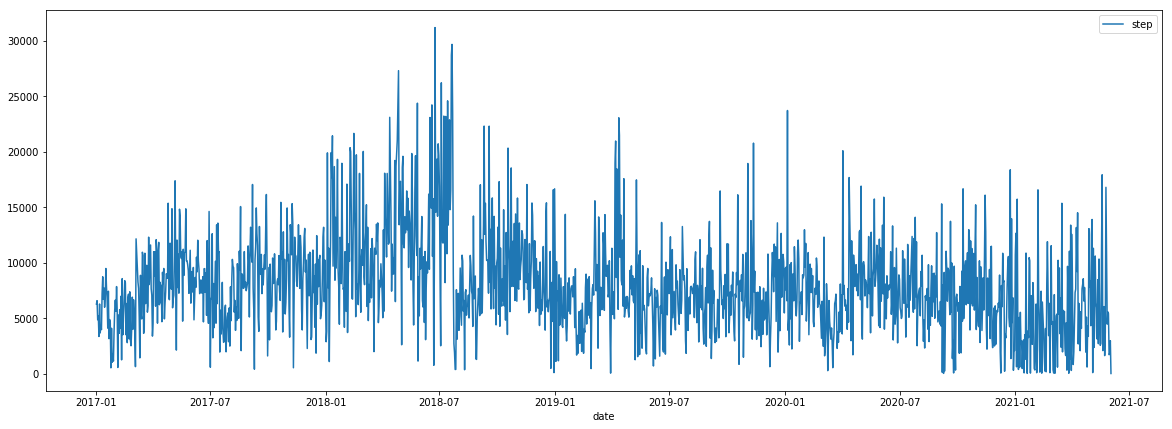

In [118]:
df_step['date'] = pd.to_datetime(df_step['date']).dt.date
df_step.plot.line(x='date', y='step', figsize=(20,7))

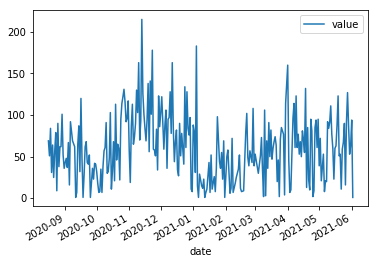

In [23]:
df_exercise.plot(kind='line', x='date', y= 'value', )

In [24]:
alt.renderers.enable('notebook')
pn.extension('vega')

In [25]:
# create list of record types to use as options
records = ['exercise']
# creates the dropdown widget
record = pn.widgets.Select(name='Record type', options=records)
# date range slider
date_range_slider = pn.widgets.DateRangeSlider(
                                        name='Date Range Slider',
                                        start=dt.datetime(2017, 1, 1), end=dt.datetime(2021, 6, 1),
                                        value=(dt.datetime(2017, 1, 1), dt.datetime(2021, 6, 1))
                                            )

title = '### Workout tracker'
subtitle = 'Select a record type and date range'

In [29]:

@pn.depends(record.param.value, date_range_slider.param.value)

def get_plot(record, date_range):
     # define df : load and format the data
    df = df_exercise
    df['date'] = pd.to_datetime(df['date'])
     # create date filter using values from the range slider
     # store the first and last date range slider value in a var
    start_date = date_range_slider.value[0] 
    end_date = date_range_slider.value[1] 
     # create filter mask for the dataframe
    mask = (df['date'] > start_date) & (df['date'] <= end_date)
     # filter the dataframe
    df = df.loc[mask] 
     # create the Altair chart object
    chart = alt.Chart(df).mark_line().encode(x='date', y='value',
                                              tooltip=alt.Tooltip(['date','value'])).transform_filter(
                                            (datum.symbol == record ) # this ties in the filter 
                                            )
    return chart

In [30]:
dashboard = pn.Row(pn.Column(title, subtitle, record, date_range_slider), get_plot)

In [31]:
dashboard.servable()

Row
    [0] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Select(name='Record type', options=['exercise'], value='exercise')
        [3] DateRangeSlider(end=datetime.datetime(2021, ..., name='Date Range Slider', start=datetime.datetime(2017, ..., value=(datetime.datetime(2017, ...)
    [1] ParamFunction(function)

https://nbviewer.jupyter.org/github/leehaesung/My_Heart_Rate_For_Time_Series_Analysis/blob/master/02_Codes/My_Heart_Rate_For_Time_Series_Analysis.ipynb